<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
!pip install torchinfo

In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torchinfo import summary

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

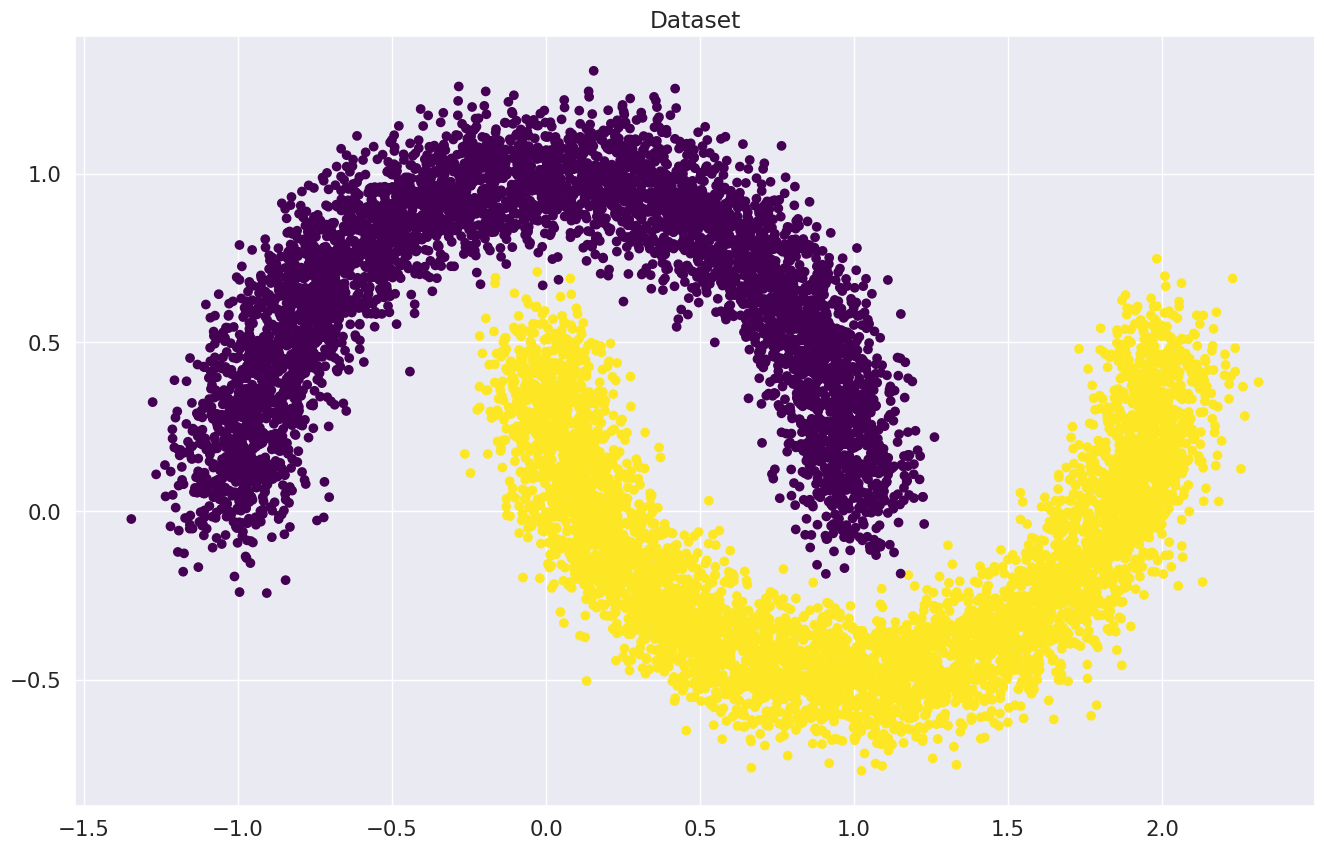

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones(out_features, requires_grad=True))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
summary(linear_regression)

Layer (type:depth-idx)                   Param #
LinearRegression                         3
Total params: 3
Trainable params: 3
Non-trainable params: 0

In [11]:
count = 0
for i in range(len(list(linear_regression.parameters()))):
  count += len(list(linear_regression.parameters())[i])

In [12]:
count

3

Ответ: 3 обучаемых параметра

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [13]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.view(-1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.8125
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 759

### Визуализируем результаты

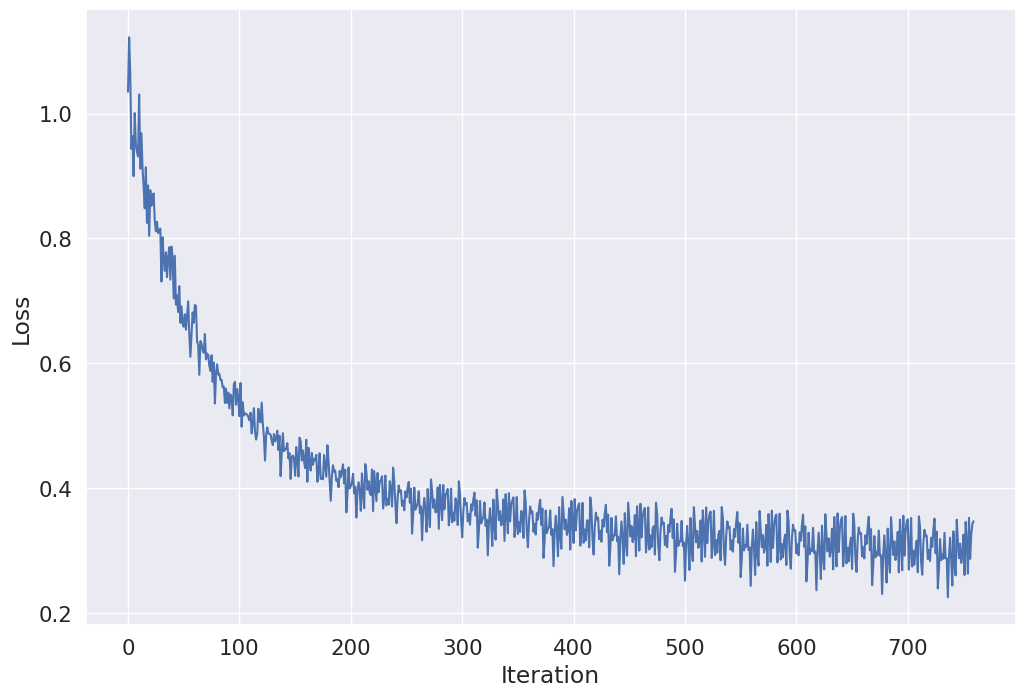

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

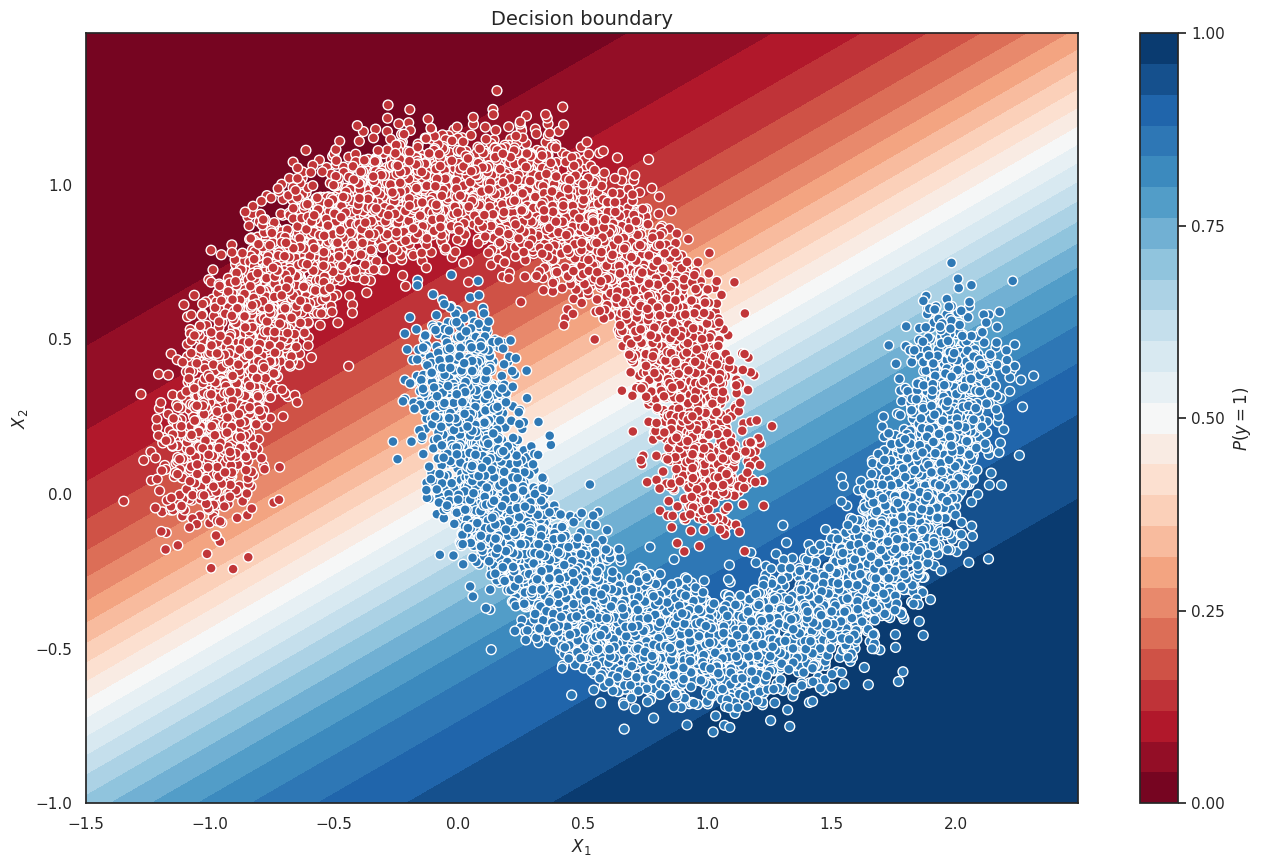

In [15]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [16]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        logits = model(x_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

0.8648

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8648

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [19]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle = True,
                              num_workers = 2)
valid_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False,
                              num_workers = 2)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [20]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [21]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [58]:
device

'cuda'

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.to(device).parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [62]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [63]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                     outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9522333333333334
Loader: valid. Accuracy: 0.9422
Epoch: 2
Loader: train. Accuracy: 0.9578166666666666
Loader: valid. Accuracy: 0.9602
Epoch: 3
Loader: train. Accuracy: 0.96165
Loader: valid. Accuracy: 0.957
Epoch: 4
Loader: train. Accuracy: 0.9644666666666667
Loader: valid. Accuracy: 0.9601
Epoch: 5
Loader: train. Accuracy: 0.9663833333333334
Loader: valid. Accuracy: 0.9657
Epoch: 6
Loader: train. Accuracy: 0.9688166666666667
Loader: valid. Accuracy: 0.9624
Epoch: 7
Loader: train. Accuracy: 0.9697666666666667
Loader: valid. Accuracy: 0.9601
Epoch: 8
Loader: train. Accuracy: 0.9716
Loader: valid. Accuracy: 0.965
Epoch: 9
Loader: train. Accuracy: 0.97225
Loader: valid. Accuracy: 0.9583
Epoch: 10
Loader: train. Accuracy: 0.9722833333333334
Loader: valid. Accuracy: 0.9603


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [64]:
elu_accuracy = accuracy["valid"]

In [65]:
def test_activation_function(activation):

    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    )

    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy['valid']

In [66]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8506666666666667
Loader: valid. Accuracy: 0.8892
Epoch: 2
Loader: train. Accuracy: 0.8826333333333334
Loader: valid. Accuracy: 0.8952
Epoch: 3
Loader: train. Accuracy: 0.88945
Loader: valid. Accuracy: 0.8889
Epoch: 4
Loader: train. Accuracy: 0.8930333333333333
Loader: valid. Accuracy: 0.898
Epoch: 5
Loader: train. Accuracy: 0.89685
Loader: valid. Accuracy: 0.9153
Epoch: 6
Loader: train. Accuracy: 0.8982333333333333
Loader: valid. Accuracy: 0.8845
Epoch: 7
Loader: train. Accuracy: 0.9004333333333333
Loader: valid. Accuracy: 0.892
Epoch: 8
Loader: train. Accuracy: 0.90065
Loader: valid. Accuracy: 0.9067
Epoch: 9
Loader: train. Accuracy: 0.9014333333333333
Loader: valid. Accuracy: 0.9141
Epoch: 10
Loader: train. Accuracy: 0.9025333333333333
Loader: valid. Accuracy: 0.8988
Epoch: 1
Loader: train. Accuracy: 0.9008333333333334
Loader: valid. Accuracy: 0.9248
Epoch: 2
Loader: train. Accuracy: 0.9437166666666666
Loader: valid. Accuracy: 0.9407
Epoch: 3
Loade

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

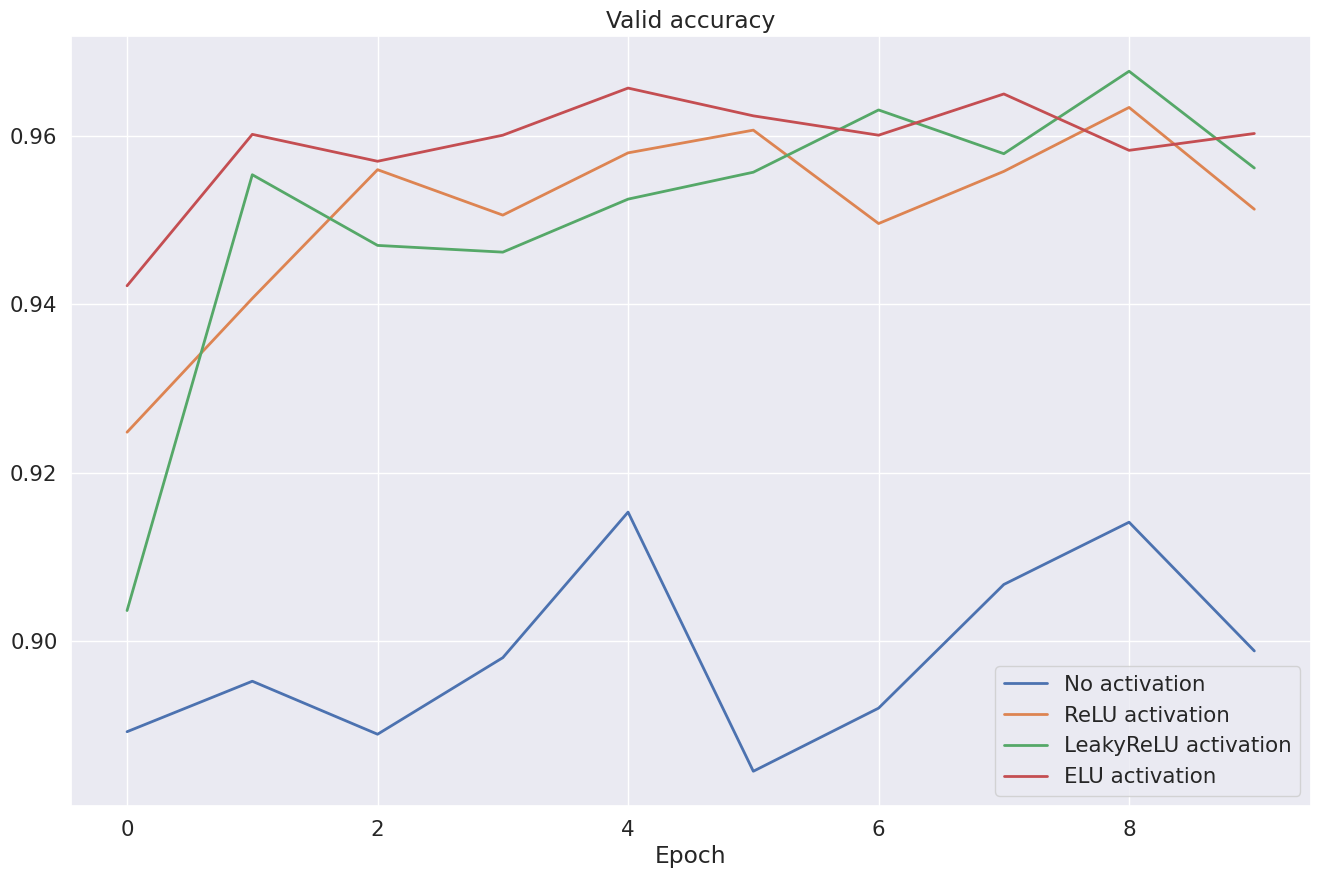

In [67]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

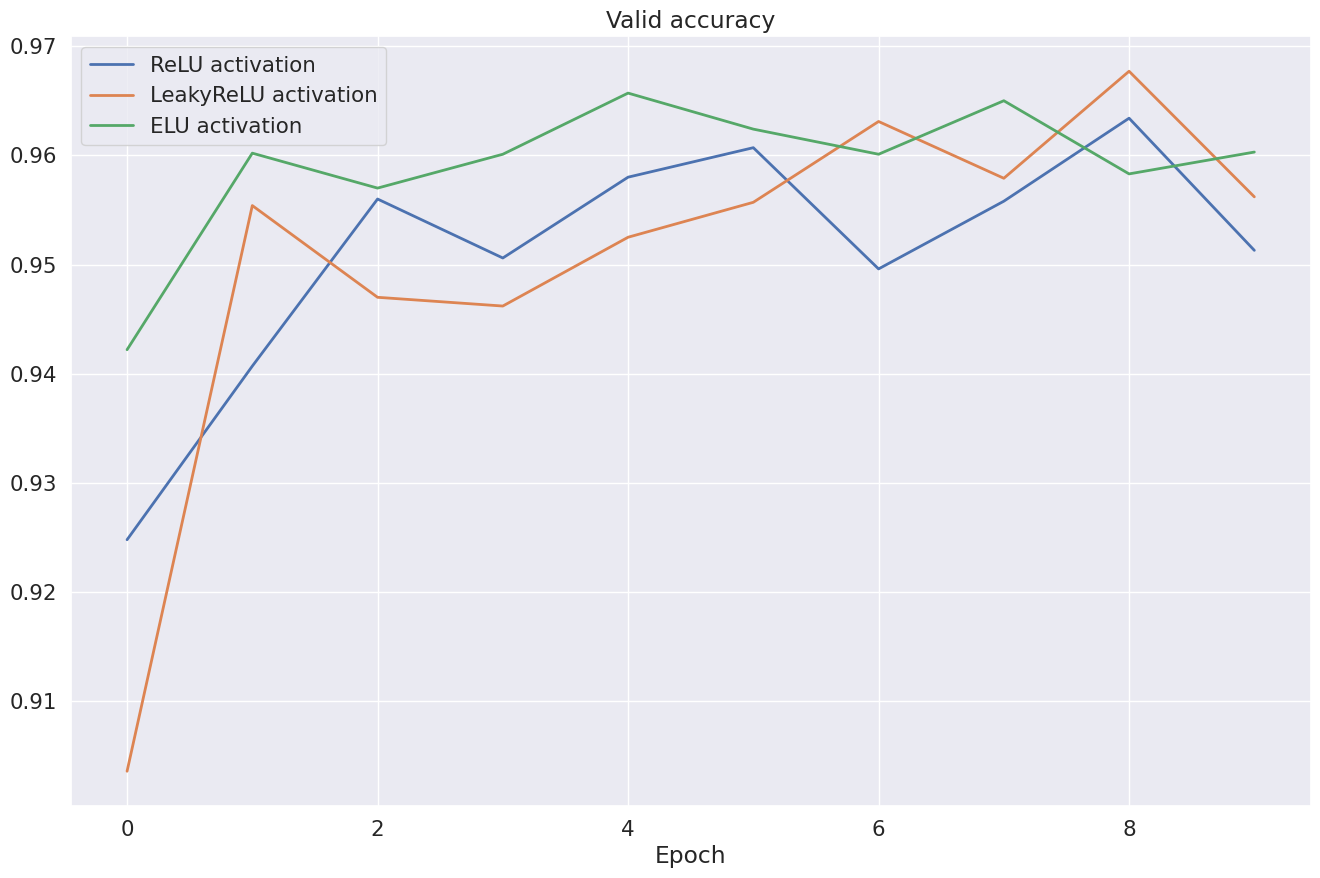

In [68]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [69]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-10-24 16:38:21--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   233KB/s    in 0.2s    

2024-10-24 16:38:22 (233 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



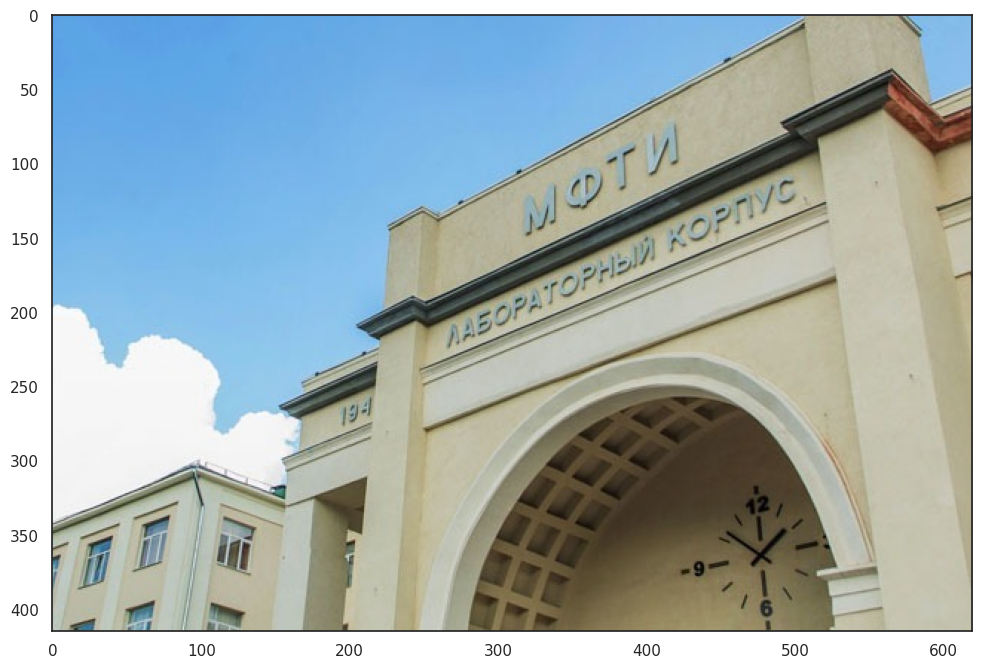

In [70]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

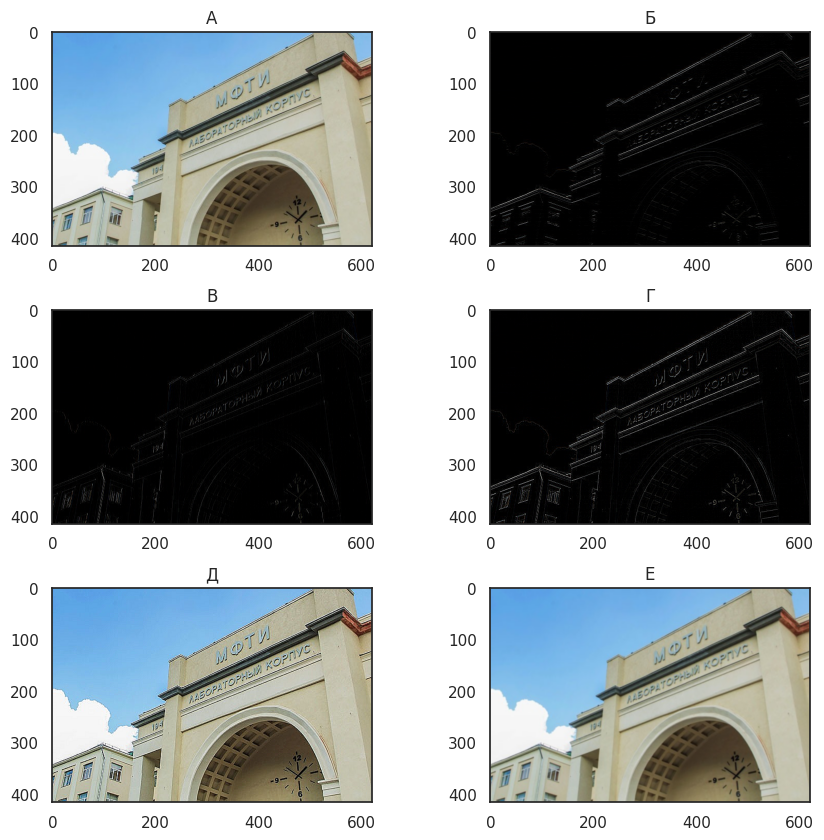

In [81]:
kernels = [
    np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ], np.float32),
    np.array([
        [0, 1, 0],
        [0, -2, 0],
        [0, 1, 0]
    ], np.float32),
    np.array([
        [0, 0, 0],
        [1, -2, 1],
        [0, 0, 0]
    ], np.float32),
    np.array([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ], np.float32),
    np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ], np.float32),
    np.array([
        [0.0625, 0.125, 0.0625],
        [0.125, 0.25, 0.125],
        [0.0625, 0.125, 0.0625]
    ], np.float32),

]
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for pos, (kernel, ax) in enumerate(zip(kernels, axes.flatten())):
    ax.set_title(chr(ord("А") + pos))
    ax.imshow(cv2.filter2D(src=RGB_img, kernel=kernel, ddepth=-1))

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1)Е 2)Д 3)А 4)В 5)Б 6)Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [111]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) #26x26x6
        self.pool1 = nn.MaxPool2d(2)    #13x13x6
        self.conv2 = nn.Conv2d(6, 16, 3) #11x11x16
        self.pool2 = nn.MaxPool2d(2)    #5x5x16
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [112]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [113]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                     outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9593166666666667
Loader: valid. Accuracy: 0.9835
Epoch: 2
Loader: train. Accuracy: 0.98385
Loader: valid. Accuracy: 0.9856
Epoch: 3
Loader: train. Accuracy: 0.98685
Loader: valid. Accuracy: 0.986
Epoch: 4
Loader: train. Accuracy: 0.98945
Loader: valid. Accuracy: 0.9853
Epoch: 5
Loader: train. Accuracy: 0.9904166666666666
Loader: valid. Accuracy: 0.9871
Epoch: 6
Loader: train. Accuracy: 0.9919833333333333
Loader: valid. Accuracy: 0.9869
Epoch: 7
Loader: train. Accuracy: 0.9922166666666666
Loader: valid. Accuracy: 0.986
Epoch: 8
Loader: train. Accuracy: 0.9927666666666667
Loader: valid. Accuracy: 0.9875
Epoch: 9
Loader: train. Accuracy: 0.9938166666666667
Loader: valid. Accuracy: 0.9869
Epoch: 10
Loader: train. Accuracy: 0.9936166666666667
Loader: valid. Accuracy: 0.9869


In [114]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

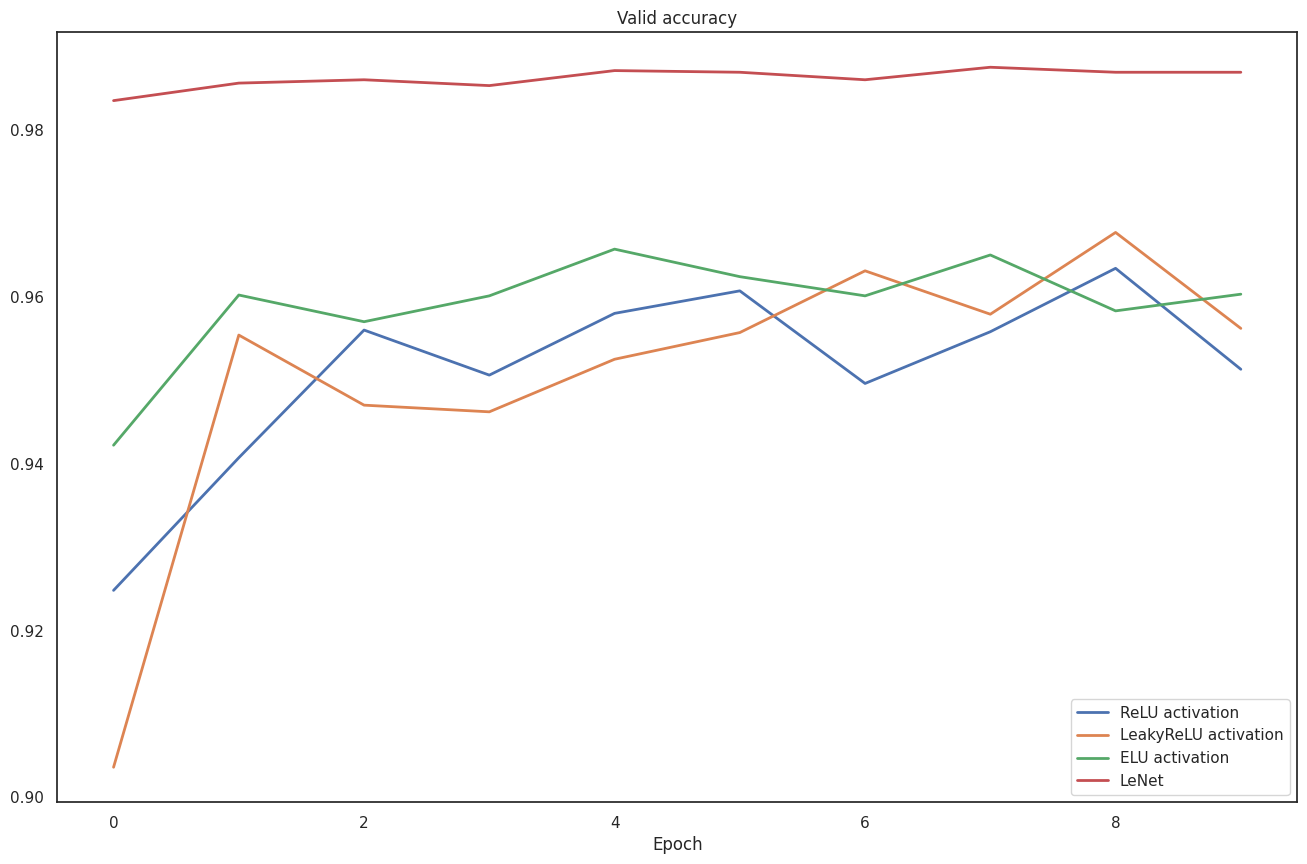

In [115]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [117]:
round(lenet_accuracy[-1], 2)

0.99

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99
